In [1]:
!pip install stable-baselines3

In [2]:
!pip install highway-env

In [3]:
import os
from pathlib import Path
import glob
import gymnasium as gym
import highway_env
from stable_baselines3 import HerReplayBuffer, SAC
from stable_baselines3.common.callbacks import EvalCallback, BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.logger import configure
import warnings

warnings.filterwarnings('ignore')

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [4]:
# ====================================================
# Base directories
# ====================================================
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/Reinforcement_learning/Stable_Baseline/SAC_Highway"
Path(BASE_DIR).mkdir(exist_ok=True)

MODEL_PATH = os.path.join(BASE_DIR, "her_sac_highway")
LOG_DIR = os.path.join(BASE_DIR, "logs")
BEST_MODEL_PATH = os.path.join(BASE_DIR, "best_model")
CHECKPOINT_DIR = os.path.join(LOG_DIR, "checkpoints")

TOTAL_TIMESTEPS = int(1e4)
EVAL_FREQ = 1000
N_EVAL_EPISODES = 5

os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(BEST_MODEL_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [5]:
# # ====================================================
# # Custom Callback: Save model + replay buffer
# # ====================================================
# class CheckpointWithBufferCallback(BaseCallback):
#     def __init__(self, save_freq, save_path, name_prefix="model_checkpoint", verbose=0):
#         super().__init__(verbose)
#         self.save_freq = save_freq
#         self.save_path = save_path
#         self.name_prefix = name_prefix
#         os.makedirs(save_path, exist_ok=True)

#     def _on_step(self) -> bool:
#         if self.n_calls % self.save_freq == 0:
#             model_file = os.path.join(self.save_path, f"{self.name_prefix}_{self.n_calls}_steps")
#             buffer_file = model_file + "_replay_buffer"

#             self.model.save(model_file)
#             self.model.save_replay_buffer(buffer_file)
#             if self.verbose > 0:
#                 print(f"✅ Saved model and replay buffer at step {self.n_calls}")
#         return True



In [6]:
class CheckpointWithBufferCallback(BaseCallback):
    def __init__(self, save_freq, save_path, name_prefix="model_checkpoint", keep_last=3, verbose=0):
        super().__init__(verbose)
        self.save_freq = save_freq
        self.save_path = save_path
        self.name_prefix = name_prefix
        self.keep_last = keep_last
        os.makedirs(save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.save_freq == 0:
            # Save model + buffer
            model_file = os.path.join(self.save_path, f"{self.name_prefix}_{self.n_calls}_steps.zip")
            buffer_file = model_file.replace(".zip", "_replay_buffer.pkl")

            self.model.save(model_file)
            self.model.save_replay_buffer(buffer_file)
            if self.verbose > 0:
                print(f"✅ Saved checkpoint at {self.n_calls} steps")

            # Cleanup old checkpoints
            self._cleanup_old_checkpoints()

        return True

    def _cleanup_old_checkpoints(self):
        ckpts = sorted(glob.glob(os.path.join(self.save_path, f"{self.name_prefix}_*_steps.zip")),
                       key=lambda x: int(x.split("_")[-2]))
        if len(ckpts) > self.keep_last:
            old_ckpts = ckpts[:len(ckpts) - self.keep_last]
            for ckpt in old_ckpts:
                buf = ckpt.replace(".zip", "_replay_buffer")
                os.remove(ckpt)
                if os.path.exists(buf):
                    os.remove(buf)
                if self.verbose > 0:
                    print(f"🗑️ Removed old checkpoint: {ckpt}")


In [7]:
# ====================================================
# Create environment
# ====================================================
env = gym.make("parking-v0")
env = Monitor(env, LOG_DIR)
env = DummyVecEnv([lambda: env])

In [8]:
# ====================================================
# Model kwargs
# ====================================================
n_sampled_goal = 4
model_kwargs = {
    "policy": "MultiInputPolicy",
    "env": env,
    "replay_buffer_class": HerReplayBuffer,
    "replay_buffer_kwargs": dict(
        n_sampled_goal=n_sampled_goal,
        goal_selection_strategy="future",
    ),
    "verbose": 1,
    "buffer_size": int(1e6),
    "learning_rate": 1e-3,
    "gamma": 0.95,
    "batch_size": 256,
    "policy_kwargs": dict(net_arch=[256, 256, 256]),
    "tensorboard_log": LOG_DIR,
}


In [9]:
# ====================================================
# Find latest checkpoint if available
# ====================================================
def get_latest_checkpoint(checkpoint_dir):
    ckpts = glob.glob(os.path.join(checkpoint_dir, "model_checkpoint_*_steps.zip"))
    if not ckpts:
        return None
    # sort by step count (extract integer from filename)
    ckpts_sorted = sorted(ckpts, key=lambda x: int(x.split("_")[-2]))
    return ckpts_sorted[-1]

latest_ckpt = get_latest_checkpoint(CHECKPOINT_DIR)


In [10]:
# ====================================================
# Load model + buffer if checkpoint or base model exists
# ====================================================
if latest_ckpt is not None:
    print(f"🔄 Resuming from latest checkpoint: {latest_ckpt}")
    model = SAC.load(latest_ckpt, env=env)
    model.set_env(env)

    # buffer_path = latest_ckpt.replace(".zip", "_replay_buffer")
    buffer_path = latest_ckpt.replace(".zip", "_replay_buffer.pkl")
    if os.path.exists(buffer_path):
        print("🔄 Loading replay buffer from checkpoint...")
        model.load_replay_buffer(buffer_path)
    else:
        print("⚠️ No replay buffer found for checkpoint, starting with empty buffer.")

elif os.path.exists(MODEL_PATH + ".zip"):
    print(f"🔄 Loading base model from {MODEL_PATH}")
    model = SAC.load(MODEL_PATH, env=env)
    model.set_env(env)

    buffer_path = MODEL_PATH + "_replay_buffer"
    if os.path.exists(buffer_path):
        print("🔄 Loading replay buffer...")
        model.load_replay_buffer(buffer_path)
    else:
        print("⚠️ No replay buffer found for base model, starting with empty buffer.")

else:
    print("🆕 Creating new model")
    model = SAC(**model_kwargs)


🔄 Resuming from latest checkpoint: /content/drive/MyDrive/Colab Notebooks/Reinforcement_learning/Stable_Baseline/SAC_Highway/logs/checkpoints/model_checkpoint_10000_steps.zip
🔄 Loading replay buffer from checkpoint...


In [11]:
# ====================================================
# Logger
# ====================================================
new_logger = configure(LOG_DIR, ["stdout", "csv", "tensorboard"])
model.set_logger(new_logger)

Logging to /content/drive/MyDrive/Colab Notebooks/Reinforcement_learning/Stable_Baseline/SAC_Highway/logs


In [12]:
# ====================================================
# Callbacks
# ====================================================
eval_callback = EvalCallback(
    env,
    best_model_save_path=BEST_MODEL_PATH,
    log_path=LOG_DIR,
    eval_freq=EVAL_FREQ,
    n_eval_episodes=N_EVAL_EPISODES,
    deterministic=True,
    render=False,
    verbose=1
)

checkpoint_with_buffer_callback = CheckpointWithBufferCallback(
    save_freq=EVAL_FREQ,
    save_path=CHECKPOINT_DIR,
    name_prefix="model_checkpoint",
    keep_last=1,
    verbose=1
)

In [13]:
# ====================================================
# Train
# ====================================================
print(f"🚀 Starting training - outputs in {BASE_DIR}")
model.learn(
    total_timesteps=TOTAL_TIMESTEPS,
    callback=[eval_callback, checkpoint_with_buffer_callback],
    tb_log_name="SAC_HER",
    reset_num_timesteps=False,   # keep logs continuous
    progress_bar=True
)

# ====================================================
# Save final model + buffer
# ====================================================
model.save(MODEL_PATH)
model.save_replay_buffer(MODEL_PATH + "_replay_buffer")

print(f"✅ Training completed. Final model saved to {MODEL_PATH}")
print(f"✅ Replay buffer saved to {MODEL_PATH}_replay_buffer")
print(f"✅ Best model saved to {BEST_MODEL_PATH}")
print(f"✅ Logs and checkpoints saved to {LOG_DIR}")

Output()

🚀 Starting training - outputs in /content/drive/MyDrive/Colab Notebooks/Reinforcement_learning/Stable_Baseline/SAC_Highway
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 80.8     |
|    ep_rew_mean     | -41.3    |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 116      |
|    fps             | 10       |
|    time_elapsed    | 3        |
|    total_timesteps | 10041    |
| train/             |          |
|    actor_loss      | 2.58     |
|    critic_loss     | 0.00992  |
|    ent_coef        | 0.0044   |
|    ent_coef_loss   | 1.56     |
|    learning_rate   | 0.001    |
|    n_updates       | 9939     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 83       |
|    ep_rew_mean     | -41      |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 120      |
|    fps             | 29  

Eval num_timesteps=11000, episode_reward=-32.04 +/- 30.09

Episode length: 132.60 +/- 186.15

Success rate: 0.00%

---------------------------------
| eval/              |          |
|    mean_ep_length  | 133      |
|    mean_reward     | -32      |
|    success_rate    | 0        |
| time/              |          |
|    total_timesteps | 11000    |
| train/             |          |
|    actor_loss      | 2.56     |
|    critic_loss     | 0.0142   |
|    ent_coef        | 0.00474  |
|    ent_coef_loss   | -0.749   |
|    learning_rate   | 0.001    |
|    n_updates       | 10898    |
---------------------------------


New best mean reward!

✅ Saved checkpoint at 1000 steps

🗑️ Removed old checkpoint: /content/drive/MyDrive/Colab 
Notebooks/Reinforcement_learning/Stable_Baseline/SAC_Highway/logs/checkpoints/model_checkpoint_1000_steps.zip

🗑️ Removed old checkpoint: /content/drive/MyDrive/Colab 
Notebooks/Reinforcement_learning/Stable_Baseline/SAC_Highway/logs/checkpoints/model_checkpoint_8000_steps.zip

🗑️ Removed old checkpoint: /content/drive/MyDrive/Colab 
Notebooks/Reinforcement_learning/Stable_Baseline/SAC_Highway/logs/checkpoints/model_checkpoint_9000_steps.zip

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 81.2     |
|    ep_rew_mean     | -39.3    |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 128      |
|    fps             | 25       |
|    time_elapsed    | 39       |
|    total_timesteps | 11025    |
| train/             |          |
|    actor_loss      | 2.4      |
|    critic_loss     | 0.01     |
|    ent_coef        | 0.00475  |
|    ent_coef_loss   | 1.77     |
|    learning_rate   | 0.001    |
|    n_updates       | 10923    |
---------------------------------


Eval num_timesteps=12000, episode_reward=-48.97 +/- 38.33

Episode length: 228.80 +/- 223.47

Success rate: 0.00%

---------------------------------
| eval/              |          |
|    mean_ep_length  | 229      |
|    mean_reward     | -49      |
|    success_rate    | 0        |
| time/              |          |
|    total_timesteps | 12000    |
| train/             |          |
|    actor_loss      | 2.39     |
|    critic_loss     | 0.0157   |
|    ent_coef        | 0.00454  |
|    ent_coef_loss   | -1.1     |
|    learning_rate   | 0.001    |
|    n_updates       | 11898    |
---------------------------------


✅ Saved checkpoint at 2000 steps

🗑️ Removed old checkpoint: /content/drive/MyDrive/Colab 
Notebooks/Reinforcement_learning/Stable_Baseline/SAC_Highway/logs/checkpoints/model_checkpoint_2000_steps.zip

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 76.9     |
|    ep_rew_mean     | -35.9    |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 136      |
|    fps             | 24       |
|    time_elapsed    | 87       |
|    total_timesteps | 12160    |
| train/             |          |
|    actor_loss      | 2.55     |
|    critic_loss     | 0.103    |
|    ent_coef        | 0.00446  |
|    ent_coef_loss   | -0.229   |
|    learning_rate   | 0.001    |
|    n_updates       | 12058    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 67.4     |
|    ep_rew_mean     | -29.6    |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 140      |
|    fps             | 25       |
|    time_elapsed    | 103      |
|    total_timesteps | 12673    |
| train/             |          |
|    actor_los

Eval num_timesteps=13000, episode_reward=-30.79 +/- 36.99

Episode length: 116.40 +/- 191.80

Success rate: 0.00%

---------------------------------
| eval/              |          |
|    mean_ep_length  | 116      |
|    mean_reward     | -30.8    |
|    success_rate    | 0        |
| time/              |          |
|    total_timesteps | 13000    |
| train/             |          |
|    actor_loss      | 2.59     |
|    critic_loss     | 0.00767  |
|    ent_coef        | 0.00431  |
|    ent_coef_loss   | 2.25     |
|    learning_rate   | 0.001    |
|    n_updates       | 12898    |
---------------------------------


New best mean reward!

✅ Saved checkpoint at 3000 steps

🗑️ Removed old checkpoint: /content/drive/MyDrive/Colab 
Notebooks/Reinforcement_learning/Stable_Baseline/SAC_Highway/logs/checkpoints/model_checkpoint_3000_steps.zip

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 72.2     |
|    ep_rew_mean     | -29.7    |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 144      |
|    fps             | 25       |
|    time_elapsed    | 135      |
|    total_timesteps | 13530    |
| train/             |          |
|    actor_loss      | 2.33     |
|    critic_loss     | 0.011    |
|    ent_coef        | 0.00432  |
|    ent_coef_loss   | 0.676    |
|    learning_rate   | 0.001    |
|    n_updates       | 13428    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 64.7     |
|    ep_rew_mean     | -25      |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 148      |
|    fps             | 26       |
|    time_elapsed    | 143      |
|    total_timesteps | 13778    |
| train/             |          |
|    actor_los

Eval num_timesteps=14000, episode_reward=-31.69 +/- 37.08

Episode length: 115.80 +/- 192.11

Success rate: 0.00%

---------------------------------
| eval/              |          |
|    mean_ep_length  | 116      |
|    mean_reward     | -31.7    |
|    success_rate    | 0        |
| time/              |          |
|    total_timesteps | 14000    |
| train/             |          |
|    actor_loss      | 2.52     |
|    critic_loss     | 0.00702  |
|    ent_coef        | 0.00403  |
|    ent_coef_loss   | 0.557    |
|    learning_rate   | 0.001    |
|    n_updates       | 13898    |
---------------------------------


✅ Saved checkpoint at 4000 steps

🗑️ Removed old checkpoint: /content/drive/MyDrive/Colab 
Notebooks/Reinforcement_learning/Stable_Baseline/SAC_Highway/logs/checkpoints/model_checkpoint_4000_steps.zip

Eval num_timesteps=15000, episode_reward=-30.63 +/- 43.73

Episode length: 115.40 +/- 192.30

Success rate: 40.00%

---------------------------------
| eval/              |          |
|    mean_ep_length  | 115      |
|    mean_reward     | -30.6    |
|    success_rate    | 0.4      |
| time/              |          |
|    total_timesteps | 15000    |
| train/             |          |
|    actor_loss      | 2.54     |
|    critic_loss     | 0.00932  |
|    ent_coef        | 0.00388  |
|    ent_coef_loss   | 1.15     |
|    learning_rate   | 0.001    |
|    n_updates       | 14898    |
---------------------------------


New best mean reward!

✅ Saved checkpoint at 5000 steps

🗑️ Removed old checkpoint: /content/drive/MyDrive/Colab 
Notebooks/Reinforcement_learning/Stable_Baseline/SAC_Highway/logs/checkpoints/model_checkpoint_5000_steps.zip

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 76.3     |
|    ep_rew_mean     | -26.9    |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 152      |
|    fps             | 25       |
|    time_elapsed    | 207      |
|    total_timesteps | 15357    |
| train/             |          |
|    actor_loss      | 2.19     |
|    critic_loss     | 0.00918  |
|    ent_coef        | 0.00371  |
|    ent_coef_loss   | -1.79    |
|    learning_rate   | 0.001    |
|    n_updates       | 15255    |
---------------------------------


Eval num_timesteps=16000, episode_reward=-71.91 +/- 34.69

Episode length: 406.60 +/- 186.80

Success rate: 20.00%

---------------------------------
| eval/              |          |
|    mean_ep_length  | 407      |
|    mean_reward     | -71.9    |
|    success_rate    | 0.2      |
| time/              |          |
|    total_timesteps | 16000    |
| train/             |          |
|    actor_loss      | 2.27     |
|    critic_loss     | 0.00826  |
|    ent_coef        | 0.00376  |
|    ent_coef_loss   | -0.0291  |
|    learning_rate   | 0.001    |
|    n_updates       | 15898    |
---------------------------------


✅ Saved checkpoint at 6000 steps

🗑️ Removed old checkpoint: /content/drive/MyDrive/Colab 
Notebooks/Reinforcement_learning/Stable_Baseline/SAC_Highway/logs/checkpoints/model_checkpoint_6000_steps.zip

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 80.1     |
|    ep_rew_mean     | -27.4    |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 156      |
|    fps             | 24       |
|    time_elapsed    | 250      |
|    total_timesteps | 16038    |
| train/             |          |
|    actor_loss      | 2.42     |
|    critic_loss     | 0.00718  |
|    ent_coef        | 0.00377  |
|    ent_coef_loss   | 1.96     |
|    learning_rate   | 0.001    |
|    n_updates       | 15936    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 82.9     |
|    ep_rew_mean     | -26.3    |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 160      |
|    fps             | 24       |
|    time_elapsed    | 274      |
|    total_timesteps | 16865    |
| train/             |          |
|    actor_los

Eval num_timesteps=17000, episode_reward=-69.05 +/- 38.22

Episode length: 317.80 +/- 223.42

Success rate: 0.00%

---------------------------------
| eval/              |          |
|    mean_ep_length  | 318      |
|    mean_reward     | -69      |
|    success_rate    | 0        |
| time/              |          |
|    total_timesteps | 17000    |
| train/             |          |
|    actor_loss      | 2.37     |
|    critic_loss     | 0.00928  |
|    ent_coef        | 0.00373  |
|    ent_coef_loss   | -0.841   |
|    learning_rate   | 0.001    |
|    n_updates       | 16898    |
---------------------------------


✅ Saved checkpoint at 7000 steps

🗑️ Removed old checkpoint: /content/drive/MyDrive/Colab 
Notebooks/Reinforcement_learning/Stable_Baseline/SAC_Highway/logs/checkpoints/model_checkpoint_7000_steps.zip

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 87.3     |
|    ep_rew_mean     | -27.2    |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 164      |
|    fps             | 24       |
|    time_elapsed    | 311      |
|    total_timesteps | 17550    |
| train/             |          |
|    actor_loss      | 2.35     |
|    critic_loss     | 0.00634  |
|    ent_coef        | 0.00352  |
|    ent_coef_loss   | -0.516   |
|    learning_rate   | 0.001    |
|    n_updates       | 17448    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 86.9     |
|    ep_rew_mean     | -26.7    |
|    success_rate    | 0.12     |
| time/              |          |
|    episodes        | 168      |
|    fps             | 24       |
|    time_elapsed    | 315      |
|    total_timesteps | 17664    |
| train/             |          |
|    actor_los

Eval num_timesteps=18000, episode_reward=-11.24 +/- 2.93

Episode length: 22.60 +/- 7.28

Success rate: 40.00%

---------------------------------
| eval/              |          |
|    mean_ep_length  | 22.6     |
|    mean_reward     | -11.2    |
|    success_rate    | 0.4      |
| time/              |          |
|    total_timesteps | 18000    |
| train/             |          |
|    actor_loss      | 2.09     |
|    critic_loss     | 0.0124   |
|    ent_coef        | 0.00363  |
|    ent_coef_loss   | 0.611    |
|    learning_rate   | 0.001    |
|    n_updates       | 17898    |
---------------------------------


New best mean reward!

✅ Saved checkpoint at 8000 steps

🗑️ Removed old checkpoint: /content/drive/MyDrive/Colab 
Notebooks/Reinforcement_learning/Stable_Baseline/SAC_Highway/logs/checkpoints/model_checkpoint_8000_steps.zip

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 86.6     |
|    ep_rew_mean     | -26.5    |
|    success_rate    | 0.14     |
| time/              |          |
|    episodes        | 172      |
|    fps             | 24       |
|    time_elapsed    | 329      |
|    total_timesteps | 18059    |
| train/             |          |
|    actor_loss      | 2.49     |
|    critic_loss     | 0.0349   |
|    ent_coef        | 0.00361  |
|    ent_coef_loss   | 0.967    |
|    learning_rate   | 0.001    |
|    n_updates       | 17957    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 86.5     |
|    ep_rew_mean     | -26.3    |
|    success_rate    | 0.16     |
| time/              |          |
|    episodes        | 176      |
|    fps             | 24       |
|    time_elapsed    | 332      |
|    total_timesteps | 18149    |
| train/             |          |
|    actor_los

Eval num_timesteps=19000, episode_reward=-35.46 +/- 34.50

Episode length: 214.60 +/- 233.09

Success rate: 40.00%

---------------------------------
| eval/              |          |
|    mean_ep_length  | 215      |
|    mean_reward     | -35.5    |
|    success_rate    | 0.4      |
| time/              |          |
|    total_timesteps | 19000    |
| train/             |          |
|    actor_loss      | 2.44     |
|    critic_loss     | 0.00636  |
|    ent_coef        | 0.0038   |
|    ent_coef_loss   | 0.1      |
|    learning_rate   | 0.001    |
|    n_updates       | 18898    |
---------------------------------


✅ Saved checkpoint at 9000 steps

🗑️ Removed old checkpoint: /content/drive/MyDrive/Colab 
Notebooks/Reinforcement_learning/Stable_Baseline/SAC_Highway/logs/checkpoints/model_checkpoint_9000_steps.zip

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 92       |
|    ep_rew_mean     | -26.6    |
|    success_rate    | 0.19     |
| time/              |          |
|    episodes        | 184      |
|    fps             | 24       |
|    time_elapsed    | 372      |
|    total_timesteps | 19078    |
| train/             |          |
|    actor_loss      | 2.49     |
|    critic_loss     | 0.0322   |
|    ent_coef        | 0.00377  |
|    ent_coef_loss   | 0.129    |
|    learning_rate   | 0.001    |
|    n_updates       | 18976    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.1     |
|    ep_rew_mean     | -26.1    |
|    success_rate    | 0.22     |
| time/              |          |
|    episodes        | 188      |
|    fps             | 24       |
|    time_elapsed    | 391      |
|    total_timesteps | 19669    |
| train/             |          |
|    actor_los

Eval num_timesteps=20000, episode_reward=-57.92 +/- 39.83

Episode length: 310.80 +/- 231.73

Success rate: 20.00%

---------------------------------
| eval/              |          |
|    mean_ep_length  | 311      |
|    mean_reward     | -57.9    |
|    success_rate    | 0.2      |
| time/              |          |
|    total_timesteps | 20000    |
| train/             |          |
|    actor_loss      | 2.29     |
|    critic_loss     | 0.00815  |
|    ent_coef        | 0.00391  |
|    ent_coef_loss   | 1.03     |
|    learning_rate   | 0.001    |
|    n_updates       | 19898    |
---------------------------------


✅ Saved checkpoint at 10000 steps

✅ Training completed. Final model saved to /content/drive/MyDrive/Colab Notebooks/Reinforcement_learning/Stable_Baseline/SAC_Highway/her_sac_highway
✅ Replay buffer saved to /content/drive/MyDrive/Colab Notebooks/Reinforcement_learning/Stable_Baseline/SAC_Highway/her_sac_highway_replay_buffer
✅ Best model saved to /content/drive/MyDrive/Colab Notebooks/Reinforcement_learning/Stable_Baseline/SAC_Highway/best_model
✅ Logs and checkpoints saved to /content/drive/MyDrive/Colab Notebooks/Reinforcement_learning/Stable_Baseline/SAC_Highway/logs


In [14]:
from stable_baselines3.common.evaluation import evaluate_policy

In [15]:
# ====================================================
# Find latest checkpoint if available
# ====================================================
def get_latest_checkpoint(checkpoint_dir):
    ckpts = glob.glob(os.path.join(checkpoint_dir, "model_checkpoint_*_steps.zip"))
    if not ckpts:
        return None
    ckpts_sorted = sorted(ckpts, key=lambda x: int(x.split("_")[-2]))
    return ckpts_sorted[-1]

latest_ckpt = get_latest_checkpoint(CHECKPOINT_DIR)

# ====================================================
# Create environment
# ====================================================
env = gym.make("parking-v0", render_mode="human")  # render so you can see
env = Monitor(env, LOG_DIR)
env = DummyVecEnv([lambda: env])

# ====================================================
# Load model (latest checkpoint > base model)
# ====================================================
if latest_ckpt is not None:
    print(f"🔄 Loading latest checkpointed model: {latest_ckpt}")
    model = SAC.load(latest_ckpt, env=env)
elif os.path.exists(MODEL_PATH + ".zip"):
    print(f"🔄 Loading base model: {MODEL_PATH}")
    model = SAC.load(MODEL_PATH, env=env)
else:
    raise FileNotFoundError("❌ No trained model or checkpoint found to evaluate.")

# ====================================================
# Evaluate model
# ====================================================
mean_reward, std_reward = evaluate_policy(
    model,
    env,
    n_eval_episodes=10,
    deterministic=True,
    render=True
)

print(f"✅ Evaluation completed over 10 episodes")
print(f"   Mean Reward: {mean_reward:.2f} ± {std_reward:.2f}")

🔄 Loading latest checkpointed model: /content/drive/MyDrive/Colab Notebooks/Reinforcement_learning/Stable_Baseline/SAC_Highway/logs/checkpoints/model_checkpoint_10000_steps.zip
✅ Evaluation completed over 10 episodes
   Mean Reward: -48.21 ± 37.01


In [16]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import os
import imageio

# LOG_DIR = "./logs"
video_dir = os.path.join(LOG_DIR, "videos")
os.makedirs(video_dir, exist_ok=True)

# Collect frames from 5 episodes into a single list
frames = []

eval_env = gym.make("parking-v0", render_mode="rgb_array")

for episode in range(5):
    obs, _ = eval_env.reset()
    done, truncated = False, False

    while not (done or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = eval_env.step(action)

        # Capture rendered frame
        frame = eval_env.render()
        frames.append(frame)

eval_env.close()

# Save all frames as a single video
output_path = os.path.join(video_dir, "five_episodes.mp4")
imageio.mimsave(output_path, frames, fps=10)

print(f"🎥 Combined video saved at: {output_path}")


🎥 Combined video saved at: /content/drive/MyDrive/Colab Notebooks/Reinforcement_learning/Stable_Baseline/SAC_Highway/logs/videos/five_episodes.mp4


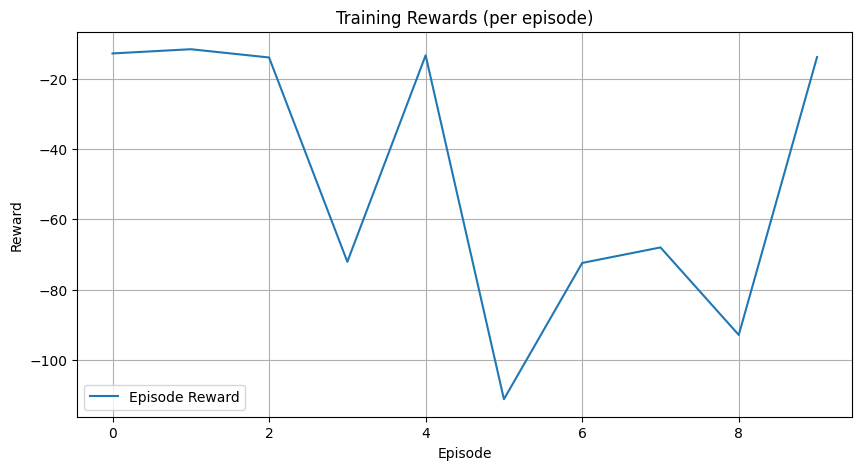

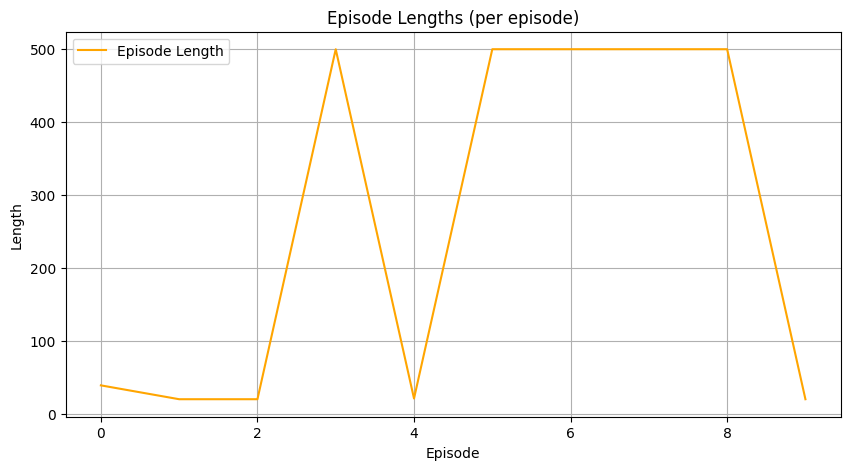

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Path to monitor file
monitor_file = os.path.join(LOG_DIR, "monitor.csv")

if os.path.exists(monitor_file):
    # Monitor CSV has a comment header, so skip it
    data = pd.read_csv(monitor_file, skiprows=1)

    # Episode rewards
    plt.figure(figsize=(10, 5))
    plt.plot(data["r"], label="Episode Reward")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Training Rewards (per episode)")
    plt.legend()
    plt.grid()
    plt.show()

    # Episode lengths
    plt.figure(figsize=(10, 5))
    plt.plot(data["l"], label="Episode Length", color="orange")
    plt.xlabel("Episode")
    plt.ylabel("Length")
    plt.title("Episode Lengths (per episode)")
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("⚠️ No monitor.csv found, make sure you wrapped env with Monitor during training.")


In [18]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import glob

# Find latest TensorBoard log directory
tb_dirs = glob.glob(os.path.join(LOG_DIR, "SAC_HER_*"))
if tb_dirs:
    tb_path = sorted(tb_dirs)[-1]
    print(f"🔎 Reading TensorBoard logs from {tb_path}")

    # Load event data
    ea = EventAccumulator(tb_path)
    ea.Reload()

    # Extract reward curve (ep_rew_mean)
    if "rollout/ep_rew_mean" in ea.Tags()["scalars"]:
        rewards = ea.Scalars("rollout/ep_rew_mean")
        steps = [s.step for s in rewards]
        values = [s.value for s in rewards]

        plt.figure(figsize=(10, 5))
        plt.plot(steps, values, label="Mean Episode Reward")
        plt.xlabel("Timesteps")
        plt.ylabel("Reward")
        plt.title("Training Reward Curve (TensorBoard)")
        plt.legend()
        plt.grid()
        plt.show()
    else:
        print("⚠️ No 'rollout/ep_rew_mean' tag found in TensorBoard logs.")
else:
    print("⚠️ No TensorBoard logs found in LOG_DIR.")


⚠️ No TensorBoard logs found in LOG_DIR.


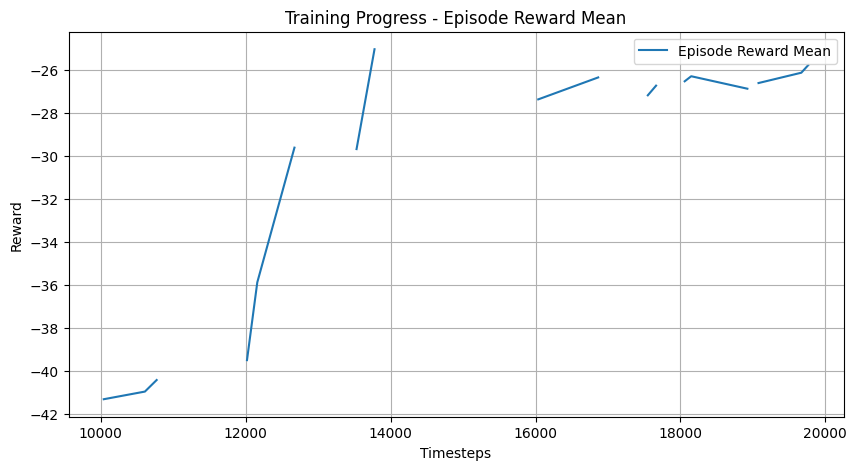

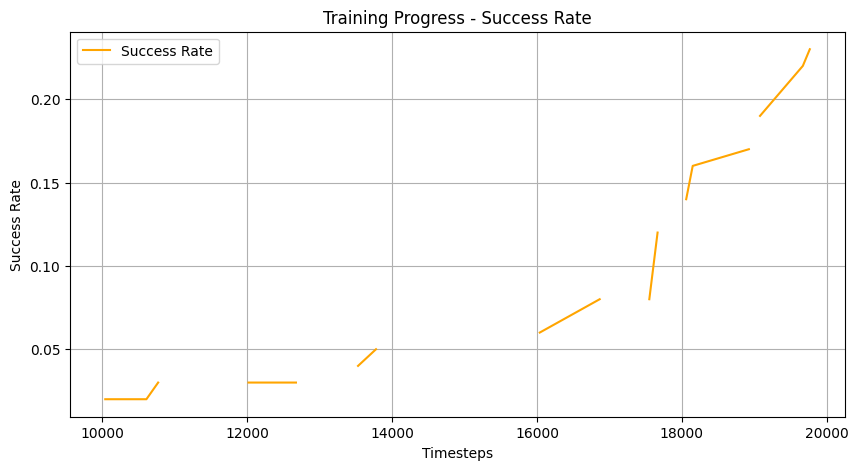

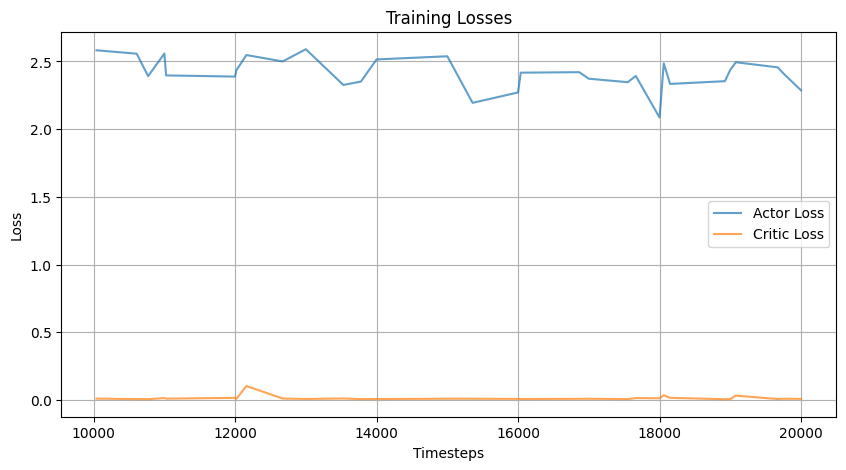

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Reinforcement_learning/Stable_Baseline/SAC_Highway/logs/progress.csv")

# Plot episode reward mean
plt.figure(figsize=(10,5))
plt.plot(df["time/total_timesteps"], df["rollout/ep_rew_mean"], label="Episode Reward Mean")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.title("Training Progress - Episode Reward Mean")
plt.legend()
plt.grid(True)
plt.show()

# Plot success rate
plt.figure(figsize=(10,5))
plt.plot(df["time/total_timesteps"], df["rollout/success_rate"], label="Success Rate", color="orange")
plt.xlabel("Timesteps")
plt.ylabel("Success Rate")
plt.title("Training Progress - Success Rate")
plt.legend()
plt.grid(True)
plt.show()

# Plot actor and critic losses
plt.figure(figsize=(10,5))
plt.plot(df["time/total_timesteps"], df["train/actor_loss"], label="Actor Loss", alpha=0.7)
plt.plot(df["time/total_timesteps"], df["train/critic_loss"], label="Critic Loss", alpha=0.7)
plt.xlabel("Timesteps")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.legend()
plt.grid(True)
plt.show()
